# 2018 KBO Mock Rookie Draft

## Formula
* WAR = RAR / 10
* RAR = RAA + 20 (PA / 600)
* RAA = wRAA + wSB + UBR + UZR + Position Constant
* wRAA = ((wOBA - league wOBA)/wOBAscale) * PA

타자<br/>
** wOBA(weight on Base Average) = (0.735 * (NIBB+HBP) + 0.90 * 1B + 1.24 * 2B + 1.56 * 3B + 1.95 * HR) / PA **


투수<br>
** FIP = { ( 13 x HR ) + ( 3 x BB ) – ( 2 x K ) } / 이닝 + cFIP **


투타 통합
WAR(Wins Above Replacement) 로 투타통합 전체순위 계산

투수 : 선발 = ((9이닝 당 대체선수 대비 기대승률) / 9) * Inning
구원 = (선발식) * ((1 + gmLI) / 2) <br>
타자 : RAR / (R/W) <br>
https://namu.wiki/w/WAR <br>

NIBB : Not Intentional base on balls(비고의4구)<br>
IBB : Intentional base on balls(고의4구)<br>
PA : Plate appearance(타석)

** References<br/> **
https://en.wikipedia.org/wiki/WOBA<br>
http://ko.yagongso.wikidok.net/wp-d/59e0e5f411f7fa6a3ea5545a/View



## 1. 타자 (wOBA)

In [336]:
import pandas as pd
import numpy as np

#Import data
hitter = pd.read_csv('2017hitter.csv')
hitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 17 columns):
순위     619 non-null int64
이름     619 non-null object
경기     619 non-null int64
타율     619 non-null float64
타석     619 non-null int64
타수     619 non-null int64
안타     619 non-null int64
2루타    619 non-null int64
3루타    619 non-null int64
홈런     619 non-null int64
타점     619 non-null int64
득점     619 non-null int64
사사구    619 non-null int64
삼진     619 non-null int64
출루율    619 non-null float64
장타율    619 non-null float64
도루     619 non-null int64
dtypes: float64(3), int64(13), object(1)
memory usage: 82.3+ KB


### Data Cleaning for Hitter 

In [337]:
#check missing value
hitter.isnull().sum()

순위     0
이름     0
경기     0
타율     0
타석     0
타수     0
안타     0
2루타    0
3루타    0
홈런     0
타점     0
득점     0
사사구    0
삼진     0
출루율    0
장타율    0
도루     0
dtype: int64

In [338]:
hitter.head()

,순위,이름,경기,타율,타석,타수,안타,2루타,3루타,홈런,타점,득점,사사구,삼진,출루율,장타율,도루
0,1,장재우(광천고),1,1.000,4,4,4,0,0,0,0,2,0,0,1.000,1.000,1
1,2,문정재(광천고),1,0.500,4,2,1,0,1,0,1,1,0,0,0.500,1.500,0
2,3,배지환(경북고),27,0.474,120,95,45,3,5,1,17,31,20,10,0.556,0.642,30
3,4,천현재(부경고),15,0.463,53,41,19,6,3,0,13,9,11,2,0.566,0.756,2
4,5,김민석(부경고),15,0.462,36,26,12,1,0,1,9,7,9,3,0.583,0.615,1


규정타석을 채우지 못한 타자들을 거를 필요가 있다 <br/>

2017년 기준
* 전반기 주말리그 7경기
* 후반기 주말리그 7경기
* 황금사자기
* 청룡선수권
* 대통령배
* 봉황대기
* 전국체전 

전국체전을 제외한 대회를 각각 2경기를 평균으로 해서 총 19경기를 소속팀 평균 경기수로 계산했다

규정타석 : 소속팀 경기수 x 0.8 x 3 = 62.4타석 <br/>
http://www.hsbaseball.kr/board/bbs_cmu_read.php?idxno=972&menu_idxno=11&page=31&search_item=&search_word=&category=

In [339]:
hitter = hitter[hitter['타석'] >= 62.4]
hitter.shape

(339, 17)

In [340]:
#단타 지표 추가
hitter['단타'] = hitter.apply(lambda x: x[6] - (x[7] + x[8] +x[9]), axis=1)
col_names = ['순위','이름','경기','타율','타석','타수','안타','단타','2루타','3루타','홈런','타점','득점','사사구','삼진','출루율','장타율','도루']
hitter = hitter.reindex(columns=col_names)
hitter.head()

,순위,이름,경기,타율,타석,타수,안타,단타,2루타,3루타,홈런,타점,득점,사사구,삼진,출루율,장타율,도루
2,3,배지환(경북고),27,0.474,120,95,45,36,3,5,1,17,31,20,10,0.556,0.642,30
8,9,강백호(서울고),31,0.434,133,106,46,30,13,0,3,34,37,27,10,0.549,0.642,10
9,10,성영래(진흥고),20,0.433,79,67,29,21,6,2,0,15,12,5,7,0.466,0.582,2
10,11,전영수(서울디자인고),17,0.431,63,51,22,17,3,1,1,4,12,11,12,0.524,0.588,11
11,12,김지훈(송탄제일고),18,0.424,79,66,28,26,1,1,0,8,18,11,7,0.494,0.470,25


### TOP 10 HITTERS by wOBA

In [341]:
#타자 종합지표 wOBA도입
hitter['wOBA'] = hitter.apply(lambda x: (0.735*x[13] + 0.9*x[7] + 1.24*x[8] + 1.56*x[9] + 1.95*x[10])/x[5], axis=1)
hitter = hitter.sort_values(by='wOBA',ascending=0)

hitter['wOBA'] = round(hitter['wOBA'],3)

hitter.head(10)

,순위,이름,경기,타율,타석,타수,안타,단타,2루타,3루타,홈런,타점,득점,사사구,삼진,출루율,장타율,도루,wOBA
23,24,김민기(덕수고),30,0.393,124,89,35,25,8,1,1,13,27,31,10,0.545,0.539,13,0.660
25,26,추재현(신일고),22,0.390,99,77,30,18,6,3,3,25,23,22,4,0.525,0.662,4,0.654
8,9,강백호(서울고),31,0.434,133,106,46,30,13,0,3,34,37,27,10,0.549,0.642,10,0.649
2,3,배지환(경북고),27,0.474,120,95,45,36,3,5,1,17,31,20,10,0.556,0.642,30,0.638
63,64,김다운(율곡고),25,0.353,115,85,30,18,8,4,0,14,34,29,7,0.518,0.541,4,0.631
145,146,박준형(북일고),16,0.311,68,45,14,10,3,1,0,14,10,19,5,0.500,0.422,3,0.628
29,30,박민석(장충고),19,0.385,86,65,25,20,2,2,1,17,21,20,7,0.529,0.523,13,0.619
149,149,강연규(북일고),16,0.310,64,42,13,11,1,1,0,8,6,18,4,0.500,0.381,2,0.617
90,89,조일현(포항제철고),21,0.338,98,68,23,17,6,0,0,11,24,26,13,0.516,0.426,7,0.615
86,87,장준환(유신고),21,0.340,68,50,17,7,8,1,1,10,16,15,5,0.485,0.600,3,0.615


## 2. 투수 (FIP)

In [342]:
pitcher = pd.read_csv('2017pitcher.csv')
pitcher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 20 columns):
순위        233 non-null int64
이름(팀명)    233 non-null object
경기        233 non-null int64
승         233 non-null int64
패         233 non-null int64
세이브       233 non-null int64
이닝        233 non-null float64
타자        233 non-null int64
타수        233 non-null int64
피안타       233 non-null int64
피홈        233 non-null int64
희생        233 non-null int64
4구        233 non-null int64
사구        233 non-null int64
삼진        233 non-null int64
실점        233 non-null int64
자책        233 non-null int64
투구        233 non-null int64
S         233 non-null int64
방어율       233 non-null float64
dtypes: float64(2), int64(17), object(1)
memory usage: 36.5+ KB


### Data Cleaning for Pitcher 

In [343]:
pitcher.isnull().sum()

순위        0
이름(팀명)    0
경기        0
승         0
패         0
세이브       0
이닝        0
타자        0
타수        0
피안타       0
피홈        0
희생        0
4구        0
사구        0
삼진        0
실점        0
자책        0
투구        0
S         0
방어율       0
dtype: int64

규정이닝 : 소속팀 경기수(26) x 0.8 = 20.8이닝 <br/>

In [344]:
pitcher = pitcher[pitcher['이닝'] >= 40]
pitcher.shape

(86, 20)

**FIP  = { ( 13 x 홈런 ) + ( 3 x 볼넷 ) – ( 2 x 삼진 ) } / 이닝 + cFIP **

### TOP 10 PITCHERS BY FIP

In [345]:
#FIP = { ( 13 x HR ) + ( 3 x BB ) – ( 2 x K ) } / 이닝 + cFIP

pitcher['FIP'] = pitcher.apply(lambda x: ( (13*x[10] + 3*x[12]) - 2*x[14])/ x[6] + 3.16, axis=1)
pitcher = pitcher.sort_values(by='FIP',ascending=True)

pitcher['FIP'] = round(pitcher['FIP'],3)

pitcher.head()

,순위,이름(팀명),경기,승,패,세이브,이닝,타자,타수,피안타,...,희생,4구,사구,삼진,실점,자책,투구,S,방어율,FIP
28,29,전용주(안산공고),23,3,1,0,40.1,157,135,26,...,4,9,5,58,10,8,610,0,1.786,1.265
13,14,양창섭(덕수고),30,7,2,0,50.1,198,178,39,...,9,7,2,56,10,8,692,0,1.431,1.344
117,118,윤강찬(김해고),13,4,4,0,66.1,276,247,64,...,8,6,15,73,36,26,994,0,3.529,1.420
26,27,이승헌(마산용마고),28,7,1,0,74.1,290,254,44,...,10,20,6,94,27,14,1095,0,1.697,1.608
6,7,최민준(경남고),30,11,1,0,81.0,315,279,42,...,4,21,11,94,15,10,1148,0,1.111,1.617


## 3. 투타통합 (WAR 기준)

### 3.1) 투수의 WAR은 fWAR을 참고한다

#### 3.1.1) RA(평균실점)

lgERA(리그평균자책점) = 리그자책점 / 리그경기(리그이닝수/9) <br>
lgRA(리그실점) = 리그실점 / 리그경기(리그이닝수/9) <br>
RAscale = lgERA / lgRA

RA = FIP / RAscale

#### 3.1.2) pR/W(1승에 해당하는 점수)

pR/W = [{9 * lgRA + IP/GS * RA + (9 - IP/GS) * lgRA} / 18 + 2] * 1.5

lgRA : 경기당 리그평균실점

IP/GS : 경기당 이닝 

#### 3.1.3) 피타고리안 기대승률(W%)

W% = {( lgRA/9 - RA) / pR/W} + .500

#### 3.1.4) 대체선수대비 기대 승률

대체선수대비 기대 승률 = W% - 0.380


#### 3.1.5) fWAR

fWAR = (대체 선수 대비 기대 승률) * IP/GS


http://www.kbreport.com/common/statDic/pitchingWAR



#### 3.1.1) RA(평균실점)

In [346]:
#리그평균실점(lgRA), 평균자책점(lgERA), RAscale

lgRA = np.sum(pitcher['실점']) / (np.sum(pitcher['이닝'] / 9))
lgERA = np.sum(pitcher['자책']) / (np.sum(pitcher['이닝'] / 9))
RAscale = lgERA / lgRA

print('lgRA = ',lgRA)
print('lgERA = ',lgERA)
print('RAscale = ',RAscale)

lgRA =  4.197607178464606
lgERA =  3.119042871385843
RAscale =  0.7430525865754597


In [347]:
pitcher['RA'] = pitcher.apply(lambda x: x[20]/RAscale, axis=1)
pitcher['RA'] = round(pitcher['RA'],3)

#### 3.1.2) pR/W(1승에 해당하는 점수)

In [348]:
pitcher['pR/W'] = pitcher.apply(lambda x: ((9 * lgRA + (x[6]/x[2]) * (x[20] / RAscale) + (9 - (x[6]/x[2])) * lgRA) / 18 + 2) * 1.5, axis=1 )
pitcher['pR/W'] = round(pitcher['pR/W'],3)

#### 3.1.3) 피타고리안 기대승률(W%)

In [349]:
pitcher['W%'] = pitcher.apply(lambda x: ((lgRA - x[21]) / x[22]) + .500, axis=1 )
pitcher['W%'] = round(pitcher['W%'],3)

#### 3.1.4) 대체선수대비 기대승률

In [350]:
pitcher['wW%'] = pitcher.apply(lambda x: x[23] - .380, axis=1 )
pitcher['wW%'] = round(pitcher['wW%'],3)

#### 3.1.5) Pitcher WAR(fWAR)

In [351]:
pitcher['fWAR'] = pitcher.apply(lambda x: x[24] / 9 * x[6], axis=1 )
pitcher = pitcher.sort_values(by='fWAR',ascending=False)

pitcher['fWAR'] = round(pitcher['fWAR'],3)


pitcher.head()

,순위,이름(팀명),경기,승,패,세이브,이닝,타자,타수,피안타,...,자책,투구,S,방어율,FIP,RA,pR/W,W%,wW%,fWAR
6,7,최민준(경남고),30,11,1,0,81.0,315,279,42,...,10,1148,0,1.111,1.617,2.176,8.842,0.729,0.349,3.141
14,15,신민혁(야탑고),23,8,3,0,81.2,307,281,49,...,13,1090,0,1.433,1.756,2.363,8.757,0.710,0.330,2.977
104,105,김범수(율곡고),25,8,2,0,87.1,350,316,79,...,32,1273,0,3.299,1.932,2.600,8.833,0.681,0.301,2.913
117,118,윤강찬(김해고),13,4,4,0,66.1,276,247,64,...,26,994,0,3.529,1.420,1.911,8.328,0.775,0.395,2.901
26,27,이승헌(마산용마고),28,7,1,0,74.1,290,254,44,...,14,1095,0,1.697,1.608,2.164,8.848,0.730,0.350,2.882


**최민준,신민혁,김범수,윤강찬,이승헌** 이 리그 정상급 투수로 분류되었다. 

### 3.2) 타자는 스탯티즈를 기준으로 계산하였다 

#### 3.2.1) Batting RAR(Runs Above Replacement level)
    
- wRAA = ((wOBA - 리그평균 wOBA) / wOBA Scale) * 타석
* RAR = RAA + 20 (PA / 600)


wOBA를 출루율 스케일로 나타내기 위해 각 이벤트(볼넷, HBP, 1루타, 2루타, 3루타, 홈런)에 곱하는 값. 이 역시 매 시즌 값이 변경되며 2012시즌 wOBA스케일은 1.245다. wOBA를 구할때 인위적으로 곱했기 때문에 다시 나누는 것. 참고로 이것도 톰 탱고의 The Book에 나온 오리지날 수치가 있는데 바로 1.15다

- RAR = 타격에서의 기여도(BRAR)

해당 지표에서는 타격에 대한 기여도만 고려할 수 있는 상황으로 나머지 지표는 제외한다.<br>
(기존은 RAR = (타격에서의 기여도(BRAR)) + (수비에서의 기여도) + (포지션에 따른 조정) + (주루에서의 기여도))


#### 3.2.2) WAR = RAR / 10  

- (R/W) 이 경우 R/W은 1승에 해당하는 득점을 10으로 통일한다)<br>
   
http://www.kbreport.com/common/statDic/positionPlayerWAR

#### 3.2) Hitter WAR

In [352]:
#리그평균 wOBA구하기
hitter['lgwOBA'] = np.mean(hitter['wOBA'])
hitter['lgwOBA'] = round(hitter['lgwOBA'], 3)


In [353]:
hitter['WAR'] = hitter.apply(lambda x: (( (((x[18] - x[19]) / 1.15) * x[4]) + (20 * x[4] / 600)) / 10), axis=1)
hitter = hitter.sort_values(by='WAR',ascending=False)

hitter['WAR'] = round(hitter['WAR'], 3)

hitter.head()

,순위,이름,경기,타율,타석,타수,안타,단타,2루타,3루타,...,타점,득점,사사구,삼진,출루율,장타율,도루,wOBA,lgwOBA,WAR
8,9,강백호(서울고),31,0.434,133,106,46,30,13,0,...,34,37,27,10,0.549,0.642,10,0.649,0.427,3.011
23,24,김민기(덕수고),30,0.393,124,89,35,25,8,1,...,13,27,31,10,0.545,0.539,13,0.660,0.427,2.926
12,13,최현준(서울고),31,0.423,141,111,47,38,6,3,...,25,40,28,13,0.536,0.532,20,0.603,0.427,2.628
2,3,배지환(경북고),27,0.474,120,95,45,36,3,5,...,17,31,20,10,0.556,0.642,30,0.638,0.427,2.602
63,64,김다운(율곡고),25,0.353,115,85,30,18,8,4,...,14,34,29,7,0.518,0.541,4,0.631,0.427,2.423


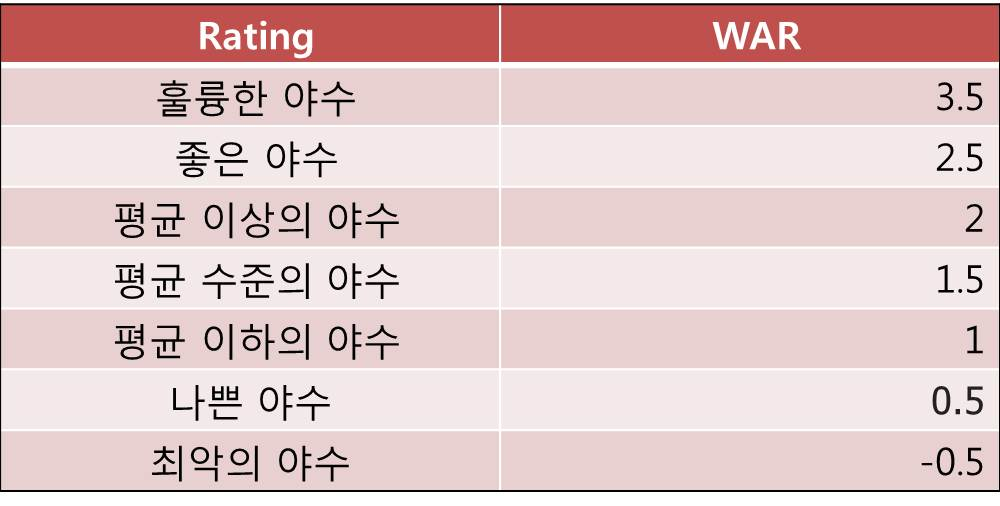

In [354]:
from IPython.display import Image
Image(filename = "C:/Users/samsung/Desktop/img02.jpg", width = 400)

**강백호, 김민기, 최현준, 배지환** 순으로 위 기준에서 **좋은 야수**로 분리된다

그러나 이는 KBO기준이므로 상대적으로 경기가 적은 고교야구에서는 WAR기준을 낮출 필요가 있다.

Ref : http://www.kbreport.com/common/statDic/positionPlayerWAR